In [1]:
from sklearn import model_selection , linear_model, metrics, pipeline,tree, preprocessing,neighbors,ensemble,svm,naive_bayes
from sklearn.model_selection import GridSearchCV,cross_val_score,train_test_split,RandomizedSearchCV,cross_val_predict
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE,RFECV

#from sklearn import model_selection import grid_search
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
from itertools import *
#from sklearn.linear_model import LogisticRegression
#from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline

In [2]:
original_train_data = pd.read_csv('./data/train.csv')
original_test_data = pd.read_csv('./data/test.csv')

In [3]:
def prepare_data(data,mode): 
    
    #Обработка пропусков
    #Заполняем медианой
    #raw_data.Age = raw_data.Age.fillna(raw_data.Age.median())
    #Заполняем медианой c группировкой
    raw_data=data.copy()
    grp = raw_data.groupby(['Sex', 'Pclass'])  
    raw_data.Age = grp.Age.apply(lambda x: x.fillna(x.median()))
    #Заполняем модой
    #raw_data.Embarked = raw_data.Embarked.fillna(raw_data.Embarked.value_counts().idxmax())
    raw_data.Embarked.fillna(raw_data.Embarked.mode()[0], inplace = True)
    raw_data.Fare.fillna(raw_data.Fare.mode()[0],inplace = True)
    #Заполняем 'N'
    raw_data.Cabin = raw_data.Cabin.fillna('NA')

    
    if mode=='new_features':
        print('--new_features mode--')
        #raw_data.Embarked.value_counts()
        #добавим новые признаки
        raw_data['Family'] = raw_data.Parch + raw_data.SibSp+1
        raw_data['Family_Size'] = pd.cut(raw_data.Family, [0,1.5,4.5,15],labels=['Single','SmallFamily','LargeFamily'])
        #raw_data['Is_Alone'] = (raw_data.Family == 0).astype(int)
        raw_data['Salutation'] = raw_data.Name.apply(lambda name: name.split(',')[1].split('.')[0].strip()) 
        raw_data['Age_Range'] = pd.cut(raw_data.Age, [0, 10, 20, 30, 40, 50, 60,70,80])
        raw_data['Fare_Category'] = pd.cut(raw_data.Fare, bins=[0,7.90,14.45,31.28,120.0,513.0],include_lowest = True, labels=['Low','Mid','High_Mid','High','Upper_High'])
        raw_data['isCabin']=raw_data.Cabin.apply(lambda x: 1 if x != 'NA' else 0)
        np.seterr(divide = 'ignore')
        raw_data['Log_Fare']=np.log10(raw_data.Fare).replace(-np.inf, 0)
        #raw_train_data.iloc[np.where(raw_train_data.Log_Fare.values<np.finfo(np.float64).min)]
        #raw_data['Fare_Category'] = pd.cut(raw_data['Fare'], bins=[0,7.90,14.45,31.28,120.0], labels=['Low','Mid','High_Mid','High'])
        #raw_data['Fare_Category'] = pd.cut(raw_data['Fare'], [0,7.90,14.45,31.28,120.0,513.0],include_lowest = True)
        #raw_data.Salutation.nunique()
        #####################New features#####################
        name_dict = {"Capt":       "officer",
                     "Col":        "officer",
                     "Major":      "officer",
                     "Dr":         "officer",
                     "Rev":        "officer",
                     "Jonkheer":   "snob",
                     "Don":        "snob",
                     "Sir" :       "snob",
                     "the Countess":"snob",
                     "Dona":       "snob",
                     "Lady" :      "snob",
                     "Mme":        "married",
                     "Ms":         "married",
                     "Mrs" :       "married",
                     "Miss" :      "single",
                     "Mlle":       "single",
                     "Mr" :        "man",
                     "Master" :    "boy"
                    }
        raw_data['Salutation_type'] = raw_data['Salutation'].map(name_dict)
        
    else:
        print('--Original mode--')
        pass
        
    return raw_data


In [4]:
def create_estimator(numeric_data_indices,categorical_data_indices,classifier):
    estimator = pipeline.Pipeline(steps = [       
        (
            'feature_processing', pipeline.FeatureUnion(transformer_list = [        
                #binary
                #('binary_variables_processing', preprocessing.FunctionTransformer(lambda data: data[:, binary_data_indices])), 
                        
                #numeric
                ('numeric_variables_processing', pipeline.Pipeline(steps = [
                    ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, numeric_data_indices],validate=False)),
                    ('scaling', preprocessing.StandardScaler())            
                            ])),
        
                #categorical
                ('categorical_variables_processing', pipeline.Pipeline(steps = [
                    ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, categorical_data_indices],validate=False)),
                    ('hot_encoding', preprocessing.OneHotEncoder(handle_unknown = 'ignore',sparse=False))            
                            ])),
            ])
        ),
        ('model_fitting', classifier)
        ]
    )
    return estimator

## Train data

In [5]:
#Подготовка с отбором признаков

#exclude_col = ['Name', 'Embarked', 'Cabin', 'isCabin','Salutation', 'Sex', 'Family']
#['Name', 'Embarked', 'Cabin', 'isCabin'] ['Salutation', 'Sex', 'Family']
#prepare_data(raw_train_data,[])



train_data=prepare_data(original_train_data,'new_features')

train_labels = train_data['Survived']
train_data.drop(['PassengerId', 'Survived'], axis = 1,inplace=True)
all_column=train_data.columns
#Описание колонок и индексов для FeatureUnion
string_data_columns = ['Name','Ticket','Cabin']
categorical_data_columns = ['Pclass','Sex','Embarked','Salutation','Age_Range', 'Fare_Category','Family_Size','Salutation_type']
numeric_data_columns = ['Age', 'SibSp', 'Parch', 'Fare','Family','isCabin','Log_Fare']
categorical_data_indices = np.array([(column in categorical_data_columns) for column in train_data.columns], dtype = bool)
numeric_data_indices = np.array([(column in numeric_data_columns) for column in train_data.columns], dtype = bool)


--new_features mode--


In [6]:
train_data.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family,Family_Size,Salutation,Age_Range,Fare_Category,isCabin,Log_Fare,Salutation_type
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NA,S,2,SmallFamily,Mr,"(20, 30]",Low,0,0.860338,man
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,2,SmallFamily,Mrs,"(30, 40]",High,1,1.852988,married
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NA,S,1,Single,Miss,"(20, 30]",Mid,0,0.898999,single
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,2,SmallFamily,Mrs,"(30, 40]",High,1,1.725095,married
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NA,S,1,Single,Mr,"(30, 40]",Mid,0,0.905796,man


In [7]:
train_data.Salutation.value_counts()

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Col               2
Major             2
the Countess      1
Mme               1
Capt              1
Sir               1
Lady              1
Don               1
Ms                1
Jonkheer          1
Name: Salutation, dtype: int64

In [8]:
#train_data.loc[:,categorical_data_indices]

## Отбор признаков

### Wrapper methods(Включение исключения)

In [10]:
def create_select_estimator(numeric_data_indices,categorical_data_indices,classifier):

    estimator = pipeline.Pipeline(steps = [       
            (
                'feature_processing', pipeline.FeatureUnion(transformer_list = [        
                    #binary
                    #('binary_variables_processing', preprocessing.FunctionTransformer(lambda data: data[:, binary_data_indices])), 

                    #numeric
                    ('numeric_variables_processing', pipeline.Pipeline(steps = [
                        ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, numeric_data_indices],validate=False)),
                        ('scaling', preprocessing.StandardScaler())            
                                ])),

                    #categorical
                    ('categorical_variables_processing', pipeline.Pipeline(steps = [
                        ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, categorical_data_indices],validate=False)),
                        ('hot_encoding', preprocessing.OneHotEncoder(handle_unknown = 'ignore',sparse=False))            
                                ])),
                ])
            ),
            #('rfecv', RFECV(estimator=clf, scoring='accuracy')) #RFE
            ('rfe', RFE(estimator=classifier, ))

            ]
        )
    return estimator

In [13]:
#all_column=numeric_data_columns+list(grid_cv.best_estimator_.steps[0][1].transformer_list[1][1].steps[1][1].get_feature_names())
#coef=grid_cv.best_estimator_.steps[1][1].coef_[0]
#sorted(zip(np.abs(coef),all_column),reverse=True)

In [15]:
classifier_dict = {'SVC':svm.SVC(kernel="linear"),'LR':linear_model.LogisticRegression(solver='lbfgs'),
                   'DeTree':tree.DecisionTreeClassifier(),
                   'GB':ensemble.GradientBoostingClassifier()}
n=1
result_df_list= []
for k, v in classifier_dict.items():
    RFE_est=create_select_estimator(numeric_data_indices,categorical_data_indices,v)
    RFE_est.fit(train_data.values, train_labels)
    
    #clf=create_estimator(current_numeric_data_indices,current_categorical_data_indices,v)
    all_column=numeric_data_columns+list(RFE_est.named_steps['feature_processing'].transformer_list[1][1].named_steps['hot_encoding'].get_feature_names())
    clf_list=[k]*len(all_column)
    #coef=list(RFE_est.named_steps['rfe'].estimator_.coef_[0])
    #coef_list=zip(np.abs(coef),all_column)
    #RFE_est.named_steps['rfe'].ranking_
    rank=list(RFE_est.named_steps['rfe'].ranking_)
    rank_list = sorted(zip(rank,all_column))
    support=list(RFE_est.named_steps['rfe'].support_)
    support_list = sorted(zip(support,all_column))
    #RFE_list=list(zip(all_column,coef,rank,support))
    RFE_df=pd.DataFrame({'clf'+str(n):clf_list,'F_name'+str(n):all_column,'rank'+str(n):rank,'support'+str(n):support})
    #result_df= pd.concat([df1, df4], axis=1)
    result_df_list.append(RFE_df)
    n+=1
result_df= pd.concat(result_df_list, axis=1)
    


In [16]:
result_df[(result_df['support1']==False) & (result_df['support2']==False) & (result_df['support3']==False) & (result_df['support4']==False)]

,clf1,F_name1,rank1,support1,clf2,F_name2,rank2,support2,clf3,F_name3,rank3,support3,clf4,F_name4,rank4,support4
23,SVC,x4_Lady,28,False,LR,x4_Lady,12,False,DeTree,x4_Lady,22,False,GB,x4_Lady,25,False
24,SVC,x4_Major,26,False,LR,x4_Major,15,False,DeTree,x4_Major,24,False,GB,x4_Major,23,False
27,SVC,x4_Mlle,27,False,LR,x4_Mlle,18,False,DeTree,x4_Mlle,25,False,GB,x4_Mlle,19,False
28,SVC,x4_Mme,25,False,LR,x4_Mme,27,False,DeTree,x4_Mme,23,False,GB,x4_Mme,22,False
34,SVC,x4_the Countess,22,False,LR,x4_the Countess,22,False,DeTree,x4_the Countess,19,False,GB,x4_the Countess,24,False
35,SVC,"x5_(0, 10]",5,False,LR,"x5_(0, 10]",28,False,DeTree,"x5_(0, 10]",6,False,GB,"x5_(0, 10]",21,False
40,SVC,"x5_(50, 60]",19,False,LR,"x5_(50, 60]",21,False,DeTree,"x5_(50, 60]",14,False,GB,"x5_(50, 60]",10,False


In [17]:
select_RFE=result_df.sort_values(by=['rank1','F_name1'],ascending=True)
#select_RFE.to_csv('select_RFE')

In [18]:
select_RFE

,clf1,F_name1,rank1,support1,clf2,F_name2,rank2,support2,clf3,F_name3,rank3,support3,clf4,F_name4,rank4,support4
3,SVC,Fare,1,True,LR,Fare,4,False,DeTree,Fare,1,True,GB,Fare,1,True
6,SVC,Log_Fare,1,True,LR,Log_Fare,1,True,DeTree,Log_Fare,1,True,GB,Log_Fare,1,True
1,SVC,SibSp,1,True,LR,SibSp,2,False,DeTree,SibSp,1,True,GB,SibSp,1,True
10,SVC,x1_female,1,True,LR,x1_female,1,True,DeTree,x1_female,1,True,GB,x1_female,1,True
11,SVC,x1_male,1,True,LR,x1_male,1,True,DeTree,x1_male,16,False,GB,x1_male,1,True
15,SVC,x3_LargeFamily,1,True,LR,x3_LargeFamily,1,True,DeTree,x3_LargeFamily,4,False,GB,x3_LargeFamily,1,True
16,SVC,x3_Single,1,True,LR,x3_Single,1,True,DeTree,x3_Single,8,False,GB,x3_Single,4,False
17,SVC,x3_SmallFamily,1,True,LR,x3_SmallFamily,1,True,DeTree,x3_SmallFamily,1,True,GB,x3_SmallFamily,12,False
18,SVC,x4_Capt,1,True,LR,x4_Capt,1,True,DeTree,x4_Capt,11,False,GB,x4_Capt,16,False
20,SVC,x4_Don,1,True,LR,x4_Don,1,True,DeTree,x4_Don,1,True,GB,x4_Don,5,False


In [46]:
#features SVC - exclude ['Parch','Age_Range','Embarked','isCabin']

### Recursive feature elimination with cross-validation

In [90]:
def create_RFECV_estimator(numeric_data_indices,categorical_data_indices,classifier):

    estimator = pipeline.Pipeline(steps = [       
            (
                'feature_processing', pipeline.FeatureUnion(transformer_list = [        
                    #binary
                    #('binary_variables_processing', preprocessing.FunctionTransformer(lambda data: data[:, binary_data_indices])), 

                    #numeric
                    ('numeric_variables_processing', pipeline.Pipeline(steps = [
                        ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, numeric_data_indices],validate=False)),
                        ('scaling', preprocessing.StandardScaler())            
                                ])),

                    #categorical
                    ('categorical_variables_processing', pipeline.Pipeline(steps = [
                        ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, categorical_data_indices],validate=False)),
                        ('hot_encoding', preprocessing.OneHotEncoder(handle_unknown = 'ignore',sparse=False))            
                                ])),
                ])
            ),
            ('rfecv', RFECV(estimator=classifier, step=1, cv=model_selection.StratifiedKFold(3),scoring='accuracy'))

            ]
        )
    return estimator

In [103]:
classifier_dict = {'SVC':svm.SVC(kernel="linear"),'LR':linear_model.LogisticRegression(solver='lbfgs'),
                   'DeTree':tree.DecisionTreeClassifier(),'GB':ensemble.GradientBoostingClassifier()}

Optimal number of features : 4


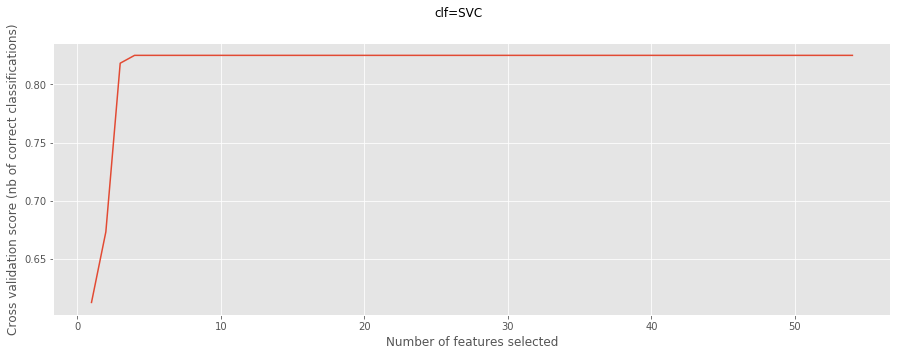

Optimal number of features : 6


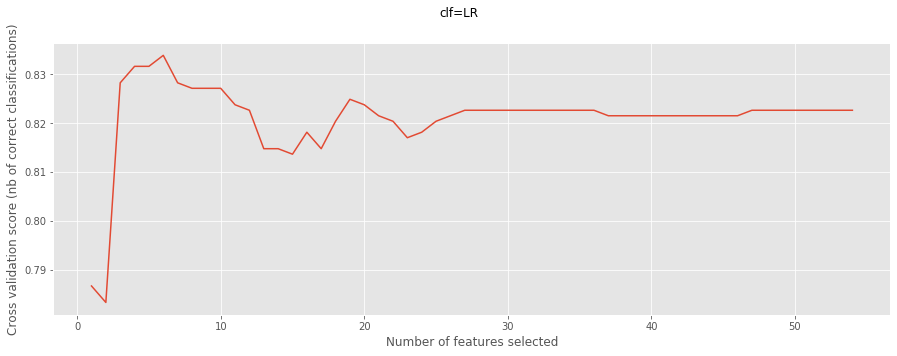

Optimal number of features : 2


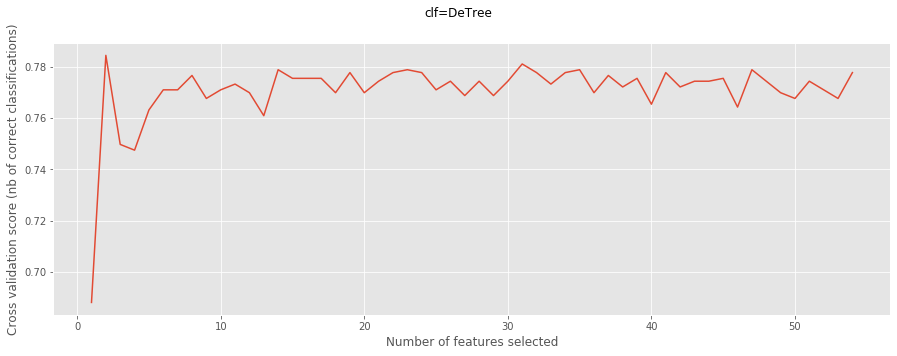

Optimal number of features : 16


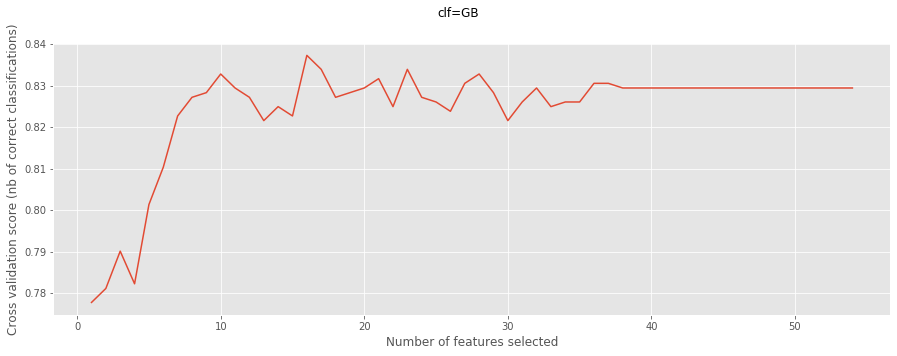

In [104]:
n=1
result_df_list= []
for k, v in classifier_dict.items():
    RFECV_estimator=create_RFECV_estimator(numeric_data_indices,categorical_data_indices,v)
    #RFE_est=create_select_estimator(numeric_data_indices,categorical_data_indices,v)
    RFECV_estimator.fit(train_data.values, train_labels)
    all_column=numeric_data_columns+list(RFECV_estimator.named_steps['feature_processing'].transformer_list[1][1].named_steps['hot_encoding'].get_feature_names())
    features_index=RFECV_estimator.named_steps['rfecv'].support_
    features_rank=RFECV_estimator.named_steps['rfecv'].ranking_
    score_list=list(RFECV_estimator.named_steps['rfecv'].grid_scores_)
    clf_list=[k]*len(features_index)
    #print('Num Features: ',RFECV_estimator.named_steps['rfecv'].n_features_)
    #print('Selected Features:', features_index)
    #print('Feature Ranking:', features_rank)
    #print('Feature Coef:', RFECV_estimator.named_steps['rfecv'].estimator_.coef_)
    RFECV_df=pd.DataFrame({'clf':clf_list,'F_name':all_column,'rank':features_rank,'support':features_index,'score':score_list})
    result_df_list.append(RFECV_df)
    print('Optimal number of features :', RFECV_estimator.named_steps['rfecv'].n_features_)

    # Plot number of features VS. cross-validation scores
    #plt.title('clf='+k)
    fig = plt.figure(figsize=(15,5))
    fig.suptitle('clf='+k)
    plt.xlabel("Number of features selected")
    plt.ylabel("Cross validation score (nb of correct classifications)")
    plt.plot(range(1, len(RFECV_estimator.named_steps['rfecv'].grid_scores_) + 1), RFECV_estimator.named_steps['rfecv'].grid_scores_)
    plt.show()

In [106]:
len(result_df_list)

4

In [108]:
result_df_list[1]

,clf,F_name,rank,support,score
0,LR,Age,14,False,0.786756
1,LR,SibSp,23,False,0.783389
2,LR,Parch,44,False,0.828283
3,LR,Fare,25,False,0.831650
4,LR,Family,11,False,0.831650
5,LR,isCabin,12,False,0.833895
6,LR,Log_Fare,8,False,0.828283
7,LR,x0_1,18,False,0.827160
8,LR,x0_2,26,False,0.827160
9,LR,x0_3,1,True,0.827160


In [82]:
RFECV_df.sort_values(by=['rank'],ascending=True)

,clf,F_name,rank,support,score
25,SVC,x4_Master,1,True,0.823801
33,SVC,x4_Sir,1,True,0.824924
48,SVC,x7_boy,1,True,0.824924
15,SVC,x3_LargeFamily,1,True,0.824931
10,SVC,x1_female,1,True,0.824931
11,SVC,x1_male,1,True,0.824931
17,SVC,x3_SmallFamily,2,False,0.823801
16,SVC,x3_Single,3,False,0.822671
22,SVC,x4_Jonkheer,4,False,0.823801
51,SVC,x7_officer,5,False,0.824924


### Перебор подмножеств признаков n<=5

In [ ]:
print('Num Features: %d',estimator.named_steps['rfe'].n_features_)
print('Selected Features:', estimator.named_steps['rfe'].support_)
print('Feature Ranking:', estimator.named_steps['rfe'].ranking_)
print('Feature Coef:', estimator.named_steps['rfe'].estimator_.coef_)

In [ ]:
#classifier_dict = {'RiC':linear_model.RidgeClassifier(),'SVC':svm.SVC(gamma='auto') ,'RF':ensemble.RandomForestClassifier(n_estimators=10),'GB':ensemble.GradientBoostingClassifier(),'KNC':neighbors.KNeighborsClassifier(),'DeTree':tree.DecisionTreeClassifier()}
classifier_dict = {'GB':ensemble.GradientBoostingClassifier()}

In [ ]:
#Сочетание без повторений
combinations_features_1=[[x] for x in all_column]
print('len combinations_features_1:',len(combinations_features_1))
combinations_features_2=[list(set().union(*x)) for x in combinations(combinations_features_1, 2)]
print('len combinations_features_2:',len(combinations_features_2))
combinations_features_3=[list(set().union(*x)) for x in combinations(combinations_features_1, 3)]
print('len combinations_features_3:',len(combinations_features_3))
combinations_features_4=[list(set().union(*x)) for x in combinations(combinations_features_1, 4)]
print('len combinations_features_4:',len(combinations_features_4))
#combinations_features_5=[list(set().union(*x)) for x in combinations(combinations_features_1, 5)]
#print('len combinations_features_5:',len(combinations_features_5))
combinations_features_all=[[]]+combinations_features_1+combinations_features_2+\
combinations_features_3+combinations_features_4#+combinations_features_5
print('len combinations_features_all:',len(combinations_features_all))

In [ ]:
%%time
# Перебор изъятия признаков


exclude_col_list=[]
clf_res_list=[]
#cv_res_list=[]
mean_res_list=[]
max_res_list=[]
min_res_list=[]
std_res_list=[]
#test_acc=[]
#for exclude_col in all_column:
for exclude_col in combinations_features_all:
    #exclude_col=list(set().union(*exclude_col_tup))
    #print(exclude_col)
    
    current_train_data=train_data.copy()
    current_train_data.drop(exclude_col, axis = 1,inplace=True)
    current_categorical_data_indices = np.array([(column in categorical_data_columns) for column in current_train_data.columns], dtype = bool)
    current_numeric_data_indices = np.array([(column in numeric_data_columns) for column in current_train_data.columns], dtype = bool)

    for k, v in classifier_dict.items():
        #print("Code : {0}, Value : {1}".format(k, v))
        #print('***Classifier*****',k)
        clf=create_estimator(current_numeric_data_indices,current_categorical_data_indices,v)
        clf_scoring = cross_val_score(clf, current_train_data.values, train_labels, scoring = 'accuracy', cv = 3)
            #print ('mean:{}, max:{}, min:{}, std:{}'.format(clf_scoring.mean(), clf_scoring.max(), clf_scoring.min(), clf_scoring.std()))
        exclude_col_list.append(exclude_col)   
        clf_res_list.append(k)
        #cv_res_list.append(name)
        mean_res_list.append(clf_scoring.mean())
        max_res_list.append(clf_scoring.max())
        min_res_list.append(clf_scoring.min())
        std_res_list.append(clf_scoring.std())
        #clf.fit(X_train, y_train)
        #y_pred=clf.predict(X_test)
        #test_acc.append(accuracy_score(y_test, y_pred))
    

In [ ]:
select_f_df=pd.DataFrame({'ex_col':exclude_col_list,'clf':clf_res_list,'mean':mean_res_list,'max':max_res_list,'min':min_res_list,'std':std_res_list})
select_f_df.sort_values(by=['mean'],ascending=False)#.head(20)

In [ ]:
select_f_df.sort_values(by=['mean'],ascending=False)#.head(20)

In [ ]:
#select_f_df.to_csv('select_f_df_origin')
select_f_df.nlargest(10, 'mean')

In [ ]:
select_f_df_max_10_mean=select_f_df[select_f_df.clf=='GB'].nlargest(10, 'mean').copy()
select_f_df_max_10_mean=select_f_df_max_10_mean.append(select_f_df[select_f_df.clf=='KNC'].nlargest(10, 'mean'))
select_f_df_max_10_mean=select_f_df_max_10_mean.append(select_f_df[select_f_df.clf=='DeTree'].nlargest(10, 'mean'))
select_f_df_max_10_mean=select_f_df_max_10_mean.append(select_f_df[select_f_df.clf=='DeTree'].nlargest(10, 'mean'))
select_f_df_max_10_mean=select_f_df_max_10_mean.append(select_f_df[select_f_df.clf=='RF'].nlargest(10, 'mean'))
select_f_df_max_10_mean=select_f_df_max_10_mean.append(select_f_df[select_f_df.clf=='SVC'].nlargest(10, 'mean'))
select_f_df_max_10_mean=select_f_df_max_10_mean.append(select_f_df[select_f_df.clf=='RiC'].nlargest(10, 'mean'))

In [ ]:
select_f_df[select_f_df.clf=='SVC'].nlargest(10, 'mean')

In [ ]:
select_f_df_max_10_mean.groupby(['clf']).max()

In [ ]:
select_f_df_max_10_mean.sort_values(by=['mean'],ascending=False).head(20)

### Разделение выборки

In [49]:
#Подготовка с отбором признаков
#exclude_col=['Age', 'Family_Size', 'Salutation', 'Fare_Category']
#features SVC - exclude 
exclude_col=['Parch','Age_Range','Embarked','isCabin']
#exclude_col = ['Name', 'Embarked', 'Cabin', 'isCabin','Salutation', 'Sex', 'Family']
#['Name', 'Embarked', 'Cabin', 'isCabin'] ['Salutation', 'Sex', 'Family']
#prepare_data(raw_train_data,[])

#current_train_data=original_train_data.copy()
#prepare_data(current_train_data,exclude_col)
#train_labels = raw_train_data['Survived']
#current_train_data = current_train_data.drop(['PassengerId', 'Survived'], axis = 1)
#print(current_train_data.columns)
#current_categorical_data_indices = np.array([(column in categorical_data_columns) for column in current_train_data.columns], dtype = bool)
#current_numeric_data_indices = np.array([(column in numeric_data_columns) for column in current_train_data.columns], dtype = bool)
#clf=create_estimator(current_numeric_data_indices,current_categorical_data_indices,v)
#clf_scoring = cross_val_score(clf, current_train_data.values, train_labels, scoring = 'accuracy', cv = 3)

current_train_data=train_data.copy()
current_train_data.drop(exclude_col, axis = 1,inplace=True)
current_categorical_data_indices = np.array([(column in categorical_data_columns) for column in current_train_data.columns], dtype = bool)
current_numeric_data_indices = np.array([(column in numeric_data_columns) for column in current_train_data.columns], dtype = bool)



In [50]:
X_train, X_test, y_train, y_test = train_test_split(current_train_data.values, train_labels, test_size=0.33,shuffle=True, random_state=42)
#stratify=train_labels
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((596, 14), (295, 14), (596,), (295,))

### Test

In [51]:
test_data=prepare_data(original_test_data,'new_features')
#current_train_data=original_train_data.copy()
#prepare_data(current_train_data,'',exclude_col)
#train_labels = train_data['Survived']
test_data.drop(['PassengerId']+exclude_col, axis = 1,inplace=True)
all_column_test=test_data.columns
#Описание колонок и индексов для FeatureUnion
#Колонки
#Проверка пропусков
NAs = pd.concat([test_data.isnull().sum()], axis=1, keys=['data'])
print('Проверка пропусков',NAs[NAs.sum(axis=1) > 0])

--new_features mode--
Проверка пропусков Empty DataFrame
Columns: [data]
Index: []


### оценка алгоритмов

In [52]:
# кросс валидация cтратегии
cv_strategy_SKF = model_selection.StratifiedKFold(n_splits = 5, shuffle = True, random_state = 0)
cv_strategy_KF =model_selection.KFold(n_splits=5, shuffle = True, random_state = 0)
cv_strategy_ShS =model_selection.ShuffleSplit(n_splits=5, train_size=0.5, test_size=.25,random_state=0)
cv_strategy_ShS =model_selection.StratifiedShuffleSplit(n_splits=5, train_size=0.5, test_size=.25,random_state=0)
cv_dict = {'SKF':cv_strategy_SKF,'KF':cv_strategy_KF,'ShS':cv_strategy_ShS,'ShS':cv_strategy_ShS}

In [53]:
classifier_dict = {'RiC':linear_model.RidgeClassifier(),'SVC':svm.SVC(gamma='auto'),'SGD':linear_model.SGDClassifier(),'LR':linear_model.LogisticRegression(solver='lbfgs'),
                   'KNC':neighbors.KNeighborsClassifier(),'DeTree':tree.DecisionTreeClassifier(),
                   'RF':ensemble.RandomForestClassifier(n_estimators=10),'GB':ensemble.GradientBoostingClassifier(),
                   'BG':ensemble.BaggingClassifier(),'NB':naive_bayes.GaussianNB()}

In [54]:
%%time
# кросс валидация оценка

clf_res_list=[]
cv_res_list=[]
mean_res_list=[]
max_res_list=[]
min_res_list=[]
std_res_list=[]
test_acc=[]
for k, v in classifier_dict.items():
    #print("Code : {0}, Value : {1}".format(k, v))
    print('***Classifier*****',k)
    clf=create_estimator(current_numeric_data_indices,current_categorical_data_indices,v)
    for name,val in cv_dict.items():
        clf_scoring = cross_val_score(clf, X_train, y_train, scoring = 'accuracy', cv = val)
        print('--cv--',name,'----',val)
        #print ('mean:{}, max:{}, min:{}, std:{}'.format(clf_scoring.mean(), clf_scoring.max(), clf_scoring.min(), clf_scoring.std()))
        clf_res_list.append(k)
        cv_res_list.append(name)
        mean_res_list.append(clf_scoring.mean())
        max_res_list.append(clf_scoring.max())
        min_res_list.append(clf_scoring.min())
        std_res_list.append(clf_scoring.std())
        clf.fit(X_train, y_train)
        y_pred=clf.predict(X_test)
        test_acc.append(accuracy_score(y_test, y_pred))

***Classifier***** RiC
--cv-- SKF ---- StratifiedKFold(n_splits=5, random_state=0, shuffle=True)
--cv-- KF ---- KFold(n_splits=5, random_state=0, shuffle=True)
--cv-- ShS ---- StratifiedShuffleSplit(n_splits=5, random_state=0, test_size=0.25,
            train_size=0.5)
***Classifier***** SVC
--cv-- SKF ---- StratifiedKFold(n_splits=5, random_state=0, shuffle=True)
--cv-- KF ---- KFold(n_splits=5, random_state=0, shuffle=True)
--cv-- ShS ---- StratifiedShuffleSplit(n_splits=5, random_state=0, test_size=0.25,
            train_size=0.5)
***Classifier***** SGD
--cv-- SKF ---- StratifiedKFold(n_splits=5, random_state=0, shuffle=True)
--cv-- KF ---- KFold(n_splits=5, random_state=0, shuffle=True)
--cv-- ShS ---- StratifiedShuffleSplit(n_splits=5, random_state=0, test_size=0.25,
            train_size=0.5)
***Classifier***** LR
--cv-- SKF ---- StratifiedKFold(n_splits=5, random_state=0, shuffle=True)
--cv-- KF ---- KFold(n_splits=5, random_state=0, shuffle=True)
--cv-- ShS ---- StratifiedSh

In [55]:
res_table=pd.DataFrame({'clf':clf_res_list, 'cv':cv_res_list,'mean':mean_res_list,'max':max_res_list,'min':min_res_list,'std':std_res_list,'test_acc':test_acc})
res_table.sort_values(by=['test_acc'],ascending=False)

,clf,cv,mean,max,min,std,test_acc
0,RiC,SKF,0.825518,0.857143,0.789916,0.027201,0.847458
2,RiC,ShS,0.822819,0.832215,0.805369,0.010045,0.847458
3,SVC,SKF,0.827199,0.865546,0.789916,0.029283,0.847458
4,SVC,KF,0.828894,0.882353,0.798319,0.030119,0.847458
5,SVC,ShS,0.830872,0.852349,0.812081,0.013014,0.847458
1,RiC,KF,0.825532,0.865546,0.806723,0.021909,0.847458
9,LR,SKF,0.823824,0.865546,0.789916,0.030537,0.837288
10,LR,KF,0.828880,0.865546,0.806723,0.021471,0.837288
11,LR,ShS,0.814765,0.832215,0.785235,0.015654,0.837288
6,SGD,SKF,0.768389,0.848739,0.647059,0.067541,0.833898


### Подбор пареметров для RidgeClassifier

In [ ]:
#SGD
#RidgeClassifier

parameters_grid = {
    'model_fitting__alpha' : [1e-3, 1e-2, 1e-1, 1,1e1,1e2], #RC
    #'model_fitting__kernel' : ['linear', 'poly', 'rbf', 'sigmoid'], #GB
    #'model_fitting__class_weight' : [None,'balanced'],
    #'model_fitting__learning_rate': [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    #'model_fitting__learning_rate': [0.2],
    #'model_fitting__min_samples_split': np.linspace(0.1, 0.5, 12),
    #'model_fitting__min_samples_leaf': np.linspace(0.1, 0.5, 12),
    #'model_fitting__max_features':["log2","sqrt"],
    #'model_fitting__criterion': ["friedman_mse",  "mae"],
    #"model_fitting__subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
    #'model_fitting__subsample':[0.85]
}

In [ ]:
clf=create_estimator(current_numeric_data_indices,current_categorical_data_indices,linear_model.RidgeClassifier(fit_intercept=False))
cv = model_selection.StratifiedKFold(n_splits = 3, shuffle = True, random_state = 0)

In [ ]:
grid_cv = GridSearchCV(clf, parameters_grid, cv = cv)

In [ ]:
grid_cv = RandomizedSearchCV(clf, parameters_grid, cv = cv,n_iter=40)

In [ ]:
%%time
#grid_cv.fit(train_data.values, train_labels)
grid_cv.fit(X_train, y_train)

print (grid_cv.best_score_)
print (grid_cv.best_params_)

In [ ]:
y_pred=grid_cv.predict(X_test)
accuracy_score(y_test, y_pred)

In [ ]:
type(grid_cv.best_estimator_[1])

In [ ]:
#Коэфициенты модели
#grid_cv.best_estimator_.steps[0][1].transformer_list[1][1].steps[0][1].fit_transform(X_train)[:2]
#one_hot_cat_col=grid_cv.best_estimator_.steps[0][1].transformer_list[1][1][1].get_feature_names(categorical_data_columns)
#grid_cv.best_estimator_.steps[0][1].transformer_list[1][1].steps[1][1].categories_
all_column=numeric_data_columns+list(grid_cv.best_estimator_.steps[0][1].transformer_list[1][1].steps[1][1].get_feature_names())
coef=grid_cv.best_estimator_.steps[1][1].coef_[0]
sorted(zip(np.abs(coef),all_column),reverse=True)

### Подбор пареметров для SVC

In [59]:
#SVC

parameters_grid = {
    'model_fitting__C' : [0.01,0.1, 1, 10, 100,], 
    #'model_fitting__C' : [0.8, 0.85, 0.9],
    'model_fitting__kernel' : ['linear','rbf', 'sigmoid'], 
    'model_fitting__class_weight' : [None,'balanced'],
    'model_fitting__decision_function_shape':['ovo', 'ovr'],
    #'model_fitting__learning_rate': [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    #'model_fitting__learning_rate': [0.2],
    #'model_fitting__min_samples_split': np.linspace(0.1, 0.5, 12),
    #'model_fitting__min_samples_leaf': np.linspace(0.1, 0.5, 12),
    #'model_fitting__max_features':["log2","sqrt"],
    #'model_fitting__criterion': ["friedman_mse",  "mae"],
    #"model_fitting__subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
    #'model_fitting__subsample':[0.85]
}

In [60]:
clf=create_estimator(current_numeric_data_indices,current_categorical_data_indices,svm.SVC())
cv = model_selection.KFold(n_splits = 3, shuffle = True, random_state = 0)

In [61]:
#clf.get_params().keys()

In [62]:
grid_cv = GridSearchCV(clf, parameters_grid, cv = cv,iid=True)

In [63]:
grid_cv = RandomizedSearchCV(clf, parameters_grid, cv = cv,n_iter=40,iid=True)

In [64]:
%%time
grid_cv.fit(X_train, y_train)
print (grid_cv.best_score_)
print (grid_cv.best_params_)

0.8288590604026845
{'model_fitting__kernel': 'rbf', 'model_fitting__decision_function_shape': 'ovr', 'model_fitting__class_weight': None, 'model_fitting__C': 1}
Wall time: 8.48 s


c:\users\guric\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


In [ ]:
y_pred=grid_cv.predict(X_test)
accuracy_score(y_test, y_pred)

### Подбор пареметров для GB

In [ ]:
#GradientBoosting

parameters_grid = {
    'model_fitting__n_estimators' : [3,4, 8, 16, 32, 64, 100], #GB
    'model_fitting__max_depth' : [3,5,7], #GB
    #'model_fitting__loss' : ["deviance",'exponential'],
    'model_fitting__learning_rate': [1, 0.5, 0.25, 0.1, 0.05, 0.01],
    #'model_fitting__learning_rate': [0.2],
    #'model_fitting__min_samples_split': np.linspace(0.1, 1, 5),
    #'model_fitting__min_samples_leaf': np.linspace(0.1, 0.5, 5),
    'model_fitting__max_features':['auto',"log2","sqrt",None],
    #'model_fitting__criterion': ["friedman_mse",  "mae"],
    #"model_fitting__subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
    #'model_fitting__subsample':[0.85]
}

In [ ]:
clf=create_estimator(current_numeric_data_indices,current_categorical_data_indices,ensemble.GradientBoostingClassifier())
cv = model_selection.KFold(n_splits = 3, shuffle = True, random_state = 0)

In [ ]:
#clf.get_params().keys()

In [ ]:
grid_cv = GridSearchCV(clf, parameters_grid, cv = cv,iid=False)

In [ ]:
grid_cv = RandomizedSearchCV(clf, parameters_grid, cv = cv,n_iter=100)

In [ ]:
%%time
grid_cv.fit(X_train, y_train)
print (grid_cv.best_score_)
print (grid_cv.best_params_)

In [ ]:
y_pred=grid_cv.predict(X_test)
accuracy_score(y_test, y_pred)

In [ ]:
#y_pred=grid_cv.predict(X_test)

In [ ]:
#accuracy_score(y_test, y_pred)

### Подбор пареметров для LR

In [ ]:
#LR

parameters_grid = {
    'model_fitting__C' : [0.001,0.01,0.1,1,10,100], #GB
    #'model_fitting__penalty' : ['l2','l1','none'],
    'model_fitting__solver' : ['newton-cg', 'lbfgs', 'liblinear']
    
}

In [ ]:
clf=create_estimator(current_numeric_data_indices,current_categorical_data_indices,linear_model.LogisticRegression(max_iter=1000))
cv = model_selection.StratifiedKFold(n_splits = 3, shuffle = True, random_state = 0)

In [ ]:
grid_cv = GridSearchCV(clf, parameters_grid, cv = cv)

In [ ]:
grid_cv = RandomizedSearchCV(clf, parameters_grid, cv = cv,n_iter=100)

In [ ]:
%%time
grid_cv.fit(X_train, y_train)
print (grid_cv.best_score_)
print (grid_cv.best_params_)

In [ ]:
y_pred=grid_cv.predict(X_test)
accuracy_score(y_test, y_pred)

### Подбор пареметров для RF

In [ ]:
#RandomForestClassifier(n_estimators=10)

parameters_grid = {
    'model_fitting__n_estimators' : [1, 2, 4, 8, 16, 32, 64, 100, 200,500], #GB
    #'model_fitting__max_depth' : np.linspace(1, 32, 32, endpoint=True), #GB
    #'model_fitting__loss' : ["deviance",'exponential'],
    #'model_fitting__learning_rate': [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    #'model_fitting__learning_rate': [0.2],
    'model_fitting__min_samples_split': [2,5,7,10],
    'model_fitting__min_samples_leaf': np.linspace(0.1, 0.5, 5, endpoint=True),
    #'model_fitting__max_features':["log2","sqrt",'auto'],
    #'model_fitting__criterion': ["friedman_mse",  "mae"],
    #"model_fitting__subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
    #'model_fitting__subsample':[0.85]
    #'model_fitting__class_weight' : ['balanced',None]
}

In [ ]:
clf=create_estimator(current_numeric_data_indices,current_categorical_data_indices,ensemble.RandomForestClassifier(class_weight='balanced'))
cv = model_selection.StratifiedKFold(n_splits = 3, shuffle = True, random_state = 0)

In [ ]:
grid_cv = GridSearchCV(clf, parameters_grid, cv = cv)

In [ ]:
grid_cv = RandomizedSearchCV(clf, parameters_grid, cv = cv,n_iter=100)

In [ ]:
%%time
grid_cv.fit(X_train, y_train)
print (grid_cv.best_score_)
print (grid_cv.best_params_)

In [ ]:
y_pred=grid_cv.predict(X_test)
accuracy_score(y_test, y_pred)

## Обучение финального классификатора ALL_TRAIN

In [ ]:
#SVC

parameters_grid = {
    'model_fitting__C' : [0.01,0.1, 1, 10, 100,], 
    #'model_fitting__C' : [0.8, 0.85, 0.9],
    'model_fitting__kernel' : ['linear','rbf', 'sigmoid'], 
    'model_fitting__class_weight' : [None,'balanced'],
    'model_fitting__decision_function_shape':['ovo', 'ovr'],
    #'model_fitting__learning_rate': [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    #'model_fitting__learning_rate': [0.2],
    #'model_fitting__min_samples_split': np.linspace(0.1, 0.5, 12),
    #'model_fitting__min_samples_leaf': np.linspace(0.1, 0.5, 12),
    #'model_fitting__max_features':["log2","sqrt"],
    #'model_fitting__criterion': ["friedman_mse",  "mae"],
    #"model_fitting__subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
    #'model_fitting__subsample':[0.85]
}

In [ ]:
clf=create_estimator(current_numeric_data_indices,current_categorical_data_indices,svm.SVC(gamma='auto'))
cv = model_selection.KFold(n_splits = 5, shuffle = True, random_state = 0)

In [ ]:
grid_cv = GridSearchCV(clf, parameters_grid, cv = cv,iid=False)

In [ ]:
grid_cv = RandomizedSearchCV(clf, parameters_grid, cv = cv,iid=False,n_iter=40)

In [ ]:
%%time
grid_cv.fit(current_train_data.values, train_labels)
print (grid_cv.best_score_)
print (grid_cv.best_params_)

### формирование файла Kaggle

In [ ]:
result = grid_cv.predict(test_data.values)
submission = pd.DataFrame({'PassengerId':original_test_data.PassengerId,'Survived':result})
submission.Survived = submission.Survived.astype(int)
print(submission.shape)


In [ ]:
filename = 'titanic18_sf_5_SVC.csv'
submission.to_csv(filename,index=False)
print('Saved file: ' + filename)

In [ ]:
#Преобразование категориальных признаков в отдельном df
#dummy_data=pd.get_dummies(data=raw_test_data, columns=categorical_data_columns)
#dummy_index=dummy_data.columns.str.contains('|'.join(categorical_data_columns))
#dummy_data=dummy_data.loc[:,dummy_index]
#Числовые данные в отдельном df
#numeric_data=raw_test_data[numeric_data_columns]
#создаем стандартный scaler
#scaler = StandardScaler()
#scaled_test_data=scaler.transform(numeric_data)
#scaled_test_data = scaler.transform(test_data)
#all_test_data=np.hstack((scaled_test_data,dummy_data.values))

### Стекинг для валидации

In [ ]:
X_train_st, X_test_st, y_train_st, y_test_st = train_test_split(train_data.values, train_labels.values, test_size=0.25, random_state=42)

In [ ]:
X_train_st.shape,y_train_st.shape,y_train_st.shape

In [ ]:
#linear_model.RidgeClassifier(alpha=10.0)
#svm.SVC(gamma='auto',C=0.8, decision_function_shape='ovo', kernel= 'linear')
#
clfs = [create_estimator(numeric_data_indices,categorical_data_indices,svm.SVC(gamma='auto',C=0.8, decision_function_shape='ovo', kernel= 'linear')),
        create_estimator(numeric_data_indices,categorical_data_indices,linear_model.LogisticRegression(solver='liblinear',class_weight=None,tol=1e-05, penalty='l2')),
        create_estimator(numeric_data_indices,categorical_data_indices,linear_model.RidgeClassifier(alpha=10.0)),
        create_estimator(numeric_data_indices,categorical_data_indices,ensemble.GradientBoostingClassifier(learning_rate= 0.1, max_depth= 3, max_features='auto', n_estimators= 32))
       ]

In [ ]:
dataset_blend_train = np.zeros((X_train_st.shape[0], len(clfs)))

In [ ]:
kf = model_selection.StratifiedKFold(n_splits=5,shuffle=False)
for j, clf in enumerate(clfs):
    print (j, clf[1])
    for i, (train_, test_) in enumerate(kf.split(X_train_st, y_train_st)):
        print ("Fold", i)
        X_tr = X_train_st[train_]
        y_tr = y_train_st[train_]
        X_te = X_train_st[test_]
        y_te = y_train_st[test_]
        clf.fit(X_tr, y_tr)
        print('------------------------',type(clf[1]))
        if isinstance(clf[1],svm.SVC) or isinstance(clf[1],linear_model.ridge.RidgeClassifier):
            print('----------SVM/RidgeCl-------')
            y_submission = clf.predict(X_te)
        else:
            print('----------Other-------')
            y_submission = clf.predict_proba(X_te)[:, 1]
        dataset_blend_train[test_, j] = y_submission

In [ ]:
isinstance(clf[1],svm.SVC),
type(clf[1])

In [ ]:
dataset_blend_train.shape

In [ ]:
clf2 = linear_model.RidgeClassifier(class_weight=None,tol=1e-05, random_state=11)
ls = cross_val_score(clf2, dataset_blend_train, y_train_st, cv=5, scoring='accuracy')
print(ls)
np.mean(ls)

In [ ]:
clf2.fit(dataset_blend_train, y_train_st)

In [ ]:
#clf2.predict()

### Тест для стекинга

In [ ]:
#kf = model_selection.StratifiedKFold(n_splits=5,shuffle=False)
X_meta = np.zeros((X_test_st.shape[0],len(clfs)))
for j, clf in enumerate(clfs):
    print (j, clf[1])
    #for i, (train_, test_) in enumerate(kf.split(train_data, train_labels)):
    #    print ("Fold", i)
    #    X_tr = train_data.values[train_]
    #    y_tr = train_labels[train_]
    #    X_te = train_data.values[test_]
    #    y_te = train_labels[test_]
    #    clf_pipeline=create_estimator(numeric_data_indices,categorical_data_indices,clf)
    #    clf_pipeline.fit(X_tr, y_tr)
    print('------------------------',type(clf[1]))
    if isinstance(clf[1],svm.SVC) or isinstance(clf[1],linear_model.ridge.RidgeClassifier):
        print('----------SVM/RidgeCl-------')
        #y_submission = clf_.predict(X_te)
        X_meta[:, j] = clf.predict(X_test_st)
    else:
        print('----------Other-------')
        #y_submission = clf_pipeline.predict_proba(X_te)[:, 1]
        X_meta[:, j] = clf.predict_proba(X_test_st)[:, 1]
    #dataset_blend_train[test_, j] = y_submission

In [ ]:
X_test.shape,X_meta.shape

In [ ]:
pred_meta=clf2.predict(X_meta)

In [ ]:
accuracy_score(y_test_st, pred_meta)

## Стекинг для ответа kaggle

In [ ]:
#linear_model.RidgeClassifier(alpha=10.0)
#svm.SVC(gamma='auto',C=0.8, decision_function_shape='ovo', kernel= 'linear')
#
clfs = [create_estimator(numeric_data_indices,categorical_data_indices,svm.SVC(gamma='auto',C=0.8, decision_function_shape='ovo', kernel= 'linear')),
        create_estimator(numeric_data_indices,categorical_data_indices,linear_model.LogisticRegression(solver='liblinear',class_weight=None,tol=1e-05, penalty='l2')),
        create_estimator(numeric_data_indices,categorical_data_indices,linear_model.RidgeClassifier(alpha=10.0)),
        create_estimator(numeric_data_indices,categorical_data_indices,ensemble.GradientBoostingClassifier(learning_rate= 0.1, max_depth= 3, max_features='auto', n_estimators= 32))
       ]

In [ ]:
X_train_st_kaggle=train_data.values
y_train_st_kaggle=train_labels.values

In [ ]:
dataset_blend_train = np.zeros((X_train_st_kaggle.shape[0], len(clfs)))

In [ ]:
kf = model_selection.StratifiedKFold(n_splits=5,shuffle=False)
for j, clf in enumerate(clfs):
    print (j, clf[1])
    for i, (train_, test_) in enumerate(kf.split(X_train_st_kaggle, y_train_st_kaggle)):
        print ("Fold", i)
        X_tr = X_train_st_kaggle[train_]
        y_tr = y_train_st_kaggle[train_]
        X_te = X_train_st_kaggle[test_]
        y_te = y_train_st_kaggle[test_]
        clf.fit(X_tr, y_tr)
        print('------------------------',type(clf[1]))
        if isinstance(clf[1],svm.SVC) or isinstance(clf[1],linear_model.ridge.RidgeClassifier):
            print('----------SVM/RidgeCl-------')
            y_submission = clf.predict(X_te)
        else:
            print('----------Other-------')
            y_submission = clf.predict_proba(X_te)[:, 1]
        dataset_blend_train[test_, j] = y_submission

In [ ]:
clf_meta_kaggle = linear_model.RidgeClassifier(class_weight=None,tol=1e-05, random_state=11)
clf_meta_kaggle.fit(dataset_blend_train, y_train_st_kaggle)

### Стекинг test для kaggle

In [ ]:
X_test_st_kaggle=test_data.values

In [ ]:
#kf = model_selection.StratifiedKFold(n_splits=5,shuffle=False)
X_meta = np.zeros((X_test_st_kaggle.shape[0],len(clfs)))
for j, clf in enumerate(clfs):
    print (j, clf[1])
    #for i, (train_, test_) in enumerate(kf.split(train_data, train_labels)):
    #    print ("Fold", i)
    #    X_tr = train_data.values[train_]
    #    y_tr = train_labels[train_]
    #    X_te = train_data.values[test_]
    #    y_te = train_labels[test_]
    #    clf_pipeline=create_estimator(numeric_data_indices,categorical_data_indices,clf)
    #    clf_pipeline.fit(X_tr, y_tr)
    print('------------------------',type(clf[1]))
    if isinstance(clf[1],svm.SVC) or isinstance(clf[1],linear_model.ridge.RidgeClassifier):
        print('----------SVM/RidgeCl-------')
        #y_submission = clf_.predict(X_te)
        X_meta[:, j] = clf.predict(X_test_st_kaggle)
    else:
        print('----------Other-------')
        #y_submission = clf_pipeline.predict_proba(X_te)[:, 1]
        X_meta[:, j] = clf.predict_proba(X_test_st_kaggle)[:, 1]
    #dataset_blend_train[test_, j] = y_submission

In [ ]:
X_meta.shape

In [ ]:
result=clf_meta_kaggle.predict(X_meta)
submission = pd.DataFrame({'PassengerId':raw_test_data.PassengerId,'Survived':result})
submission.Survived = submission.Survived.astype(int)
print(submission.shape)

In [ ]:
filename = 'titanic16_stack.csv'
submission.to_csv(filename,index=False)
print('Saved file: ' + filename)

In [ ]:
string_data_columns = ['Name','Ticket','Cabin']
categorical_data_columns = ['Pclass','Sex','Embarked','Salutation','Age_Range', 'Fare_Category','Family_Size','Salutation_type']
numeric_data_columns = ['Age', 'SibSp', 'Parch', 'Fare','Family','isCabin','Log_Fare']
#numeric_data_columns = ['Family']